In [6]:
import os, gc, torch

import numpy as np
import pandas as pd
# from models.load import TrainedModels

from utils.eval import save_iou_results
from utils.engine import xami_evaluate, get_iou_types
from models.load import get_trained_model
from utils.train import get_coco_eval_params, get_dynamic_loss, get_params
from utils.coco_eval import get_eval_params_dict
from data.datasets import  collate_fn
from utils.coco_utils import get_cocos, get_coco_api_from_dataset
from utils.eval import get_ap_ar
from utils.print import print_title
from utils.init import reproducibility, clean_memory_get_device
from data.load import get_datasets, get_dataloaders
from data.paths import XAMI_MIMIC_PATH
from data.constants import DEFAULT_REFLACX_LABEL_COLS, FULL_IOU_THRS, IOU_THRS_5_TO_95
from data.load  import seed_worker, get_dataloader_g
from utils.train import get_optimiser, get_lr_scheduler, print_params_setup, get_coco_eval_params, get_dynamic_loss, get_params
from utils.plot import plot_losses, plot_ap_ars

from tqdm import tqdm

## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [3]:
from enum import Enum

class TrainedModels(Enum):
    # CXR_images="val_ar_0_0487_ap_0_0112_test_ar_0_0494_ap_0_0124_epoch100_11-07-2022 19-23-44_All_label_testing"    
    CXR_image_5_labels = "val_ar_0_5178_ap_0_2403_test_ar_0_5277_ap_0_2606_epoch50_11-17-2022 08-48-30_label_testing"

In [4]:
select_model = TrainedModels.CXR_image_5_labels

model, train_info, _, _ = get_trained_model(
        select_model,
        DEFAULT_REFLACX_LABEL_COLS,
        device,
        rpn_nms_thresh=0.3,
        box_detections_per_img=10,
        box_nms_thresh=0.2,
        rpn_score_thresh=0.0,
        box_score_thresh=0.05,
    )

Using pretrained backbone. mobilenet_v3
label_testing will use mask, [64] layers.
Using SGD as optimizer with lr=0.001


[model]: 3,491,471
[model.backbone]: 1,258,848
[model.rpn]: 41,803
[model.roi_heads]: 2,190,820
[model.roi_heads.box_head]: 204,928
[model.roi_heads.box_head.fc6]: 200,768
[model.roi_heads.box_head.fc7]: 4,160
[model.roi_heads.box_predictor]: 1,950
[model.roi_heads.mask_head]: 1,917,952
Max AP on test: [0.2606]


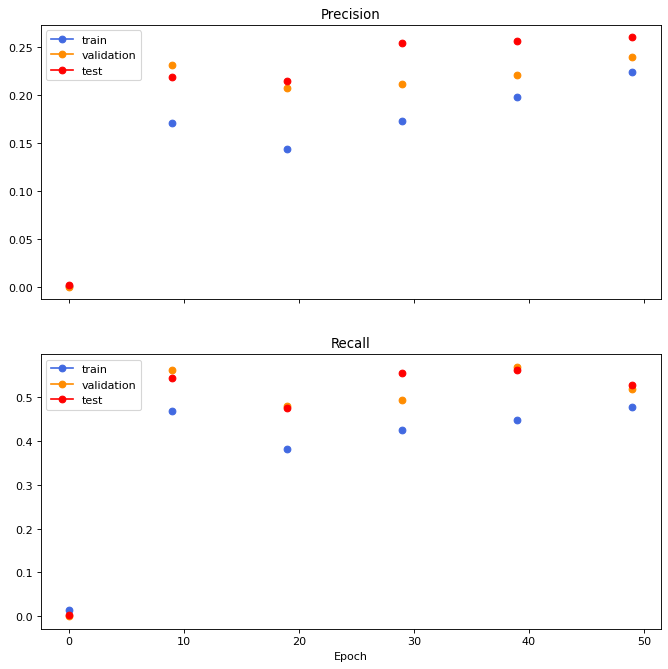

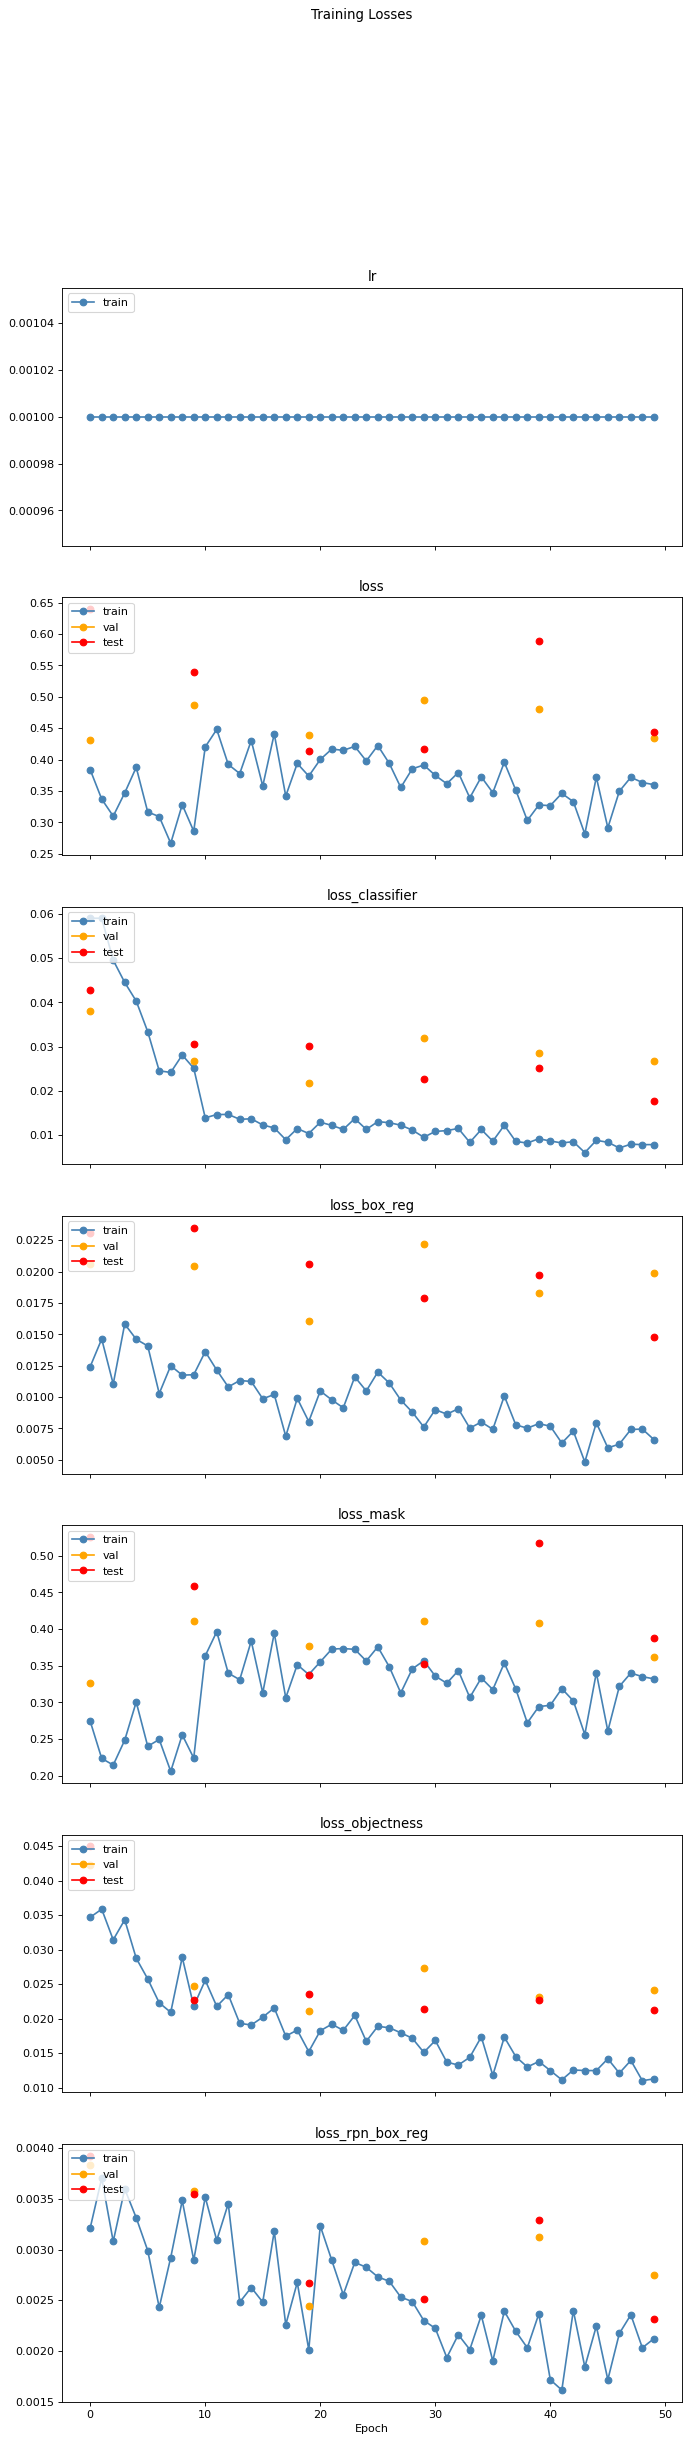

In [7]:
model_setup = train_info.model_setup
print_params_setup(model)
print(f"Max AP on test: [{max([ap_ar['ap']  for ap_ar in  train_info.test_ap_ars]):.4f}]")

plot_ap_ars(
        train_ap_ars=train_info.train_ap_ars,
        val_ap_ars=train_info.val_ap_ars,
        test_ap_ars=train_info.test_ap_ars,
    )

plot_losses(train_info.train_losses, train_info.val_losses, test_logers=train_info.test_losses)